In [1]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import math
import numpy as np



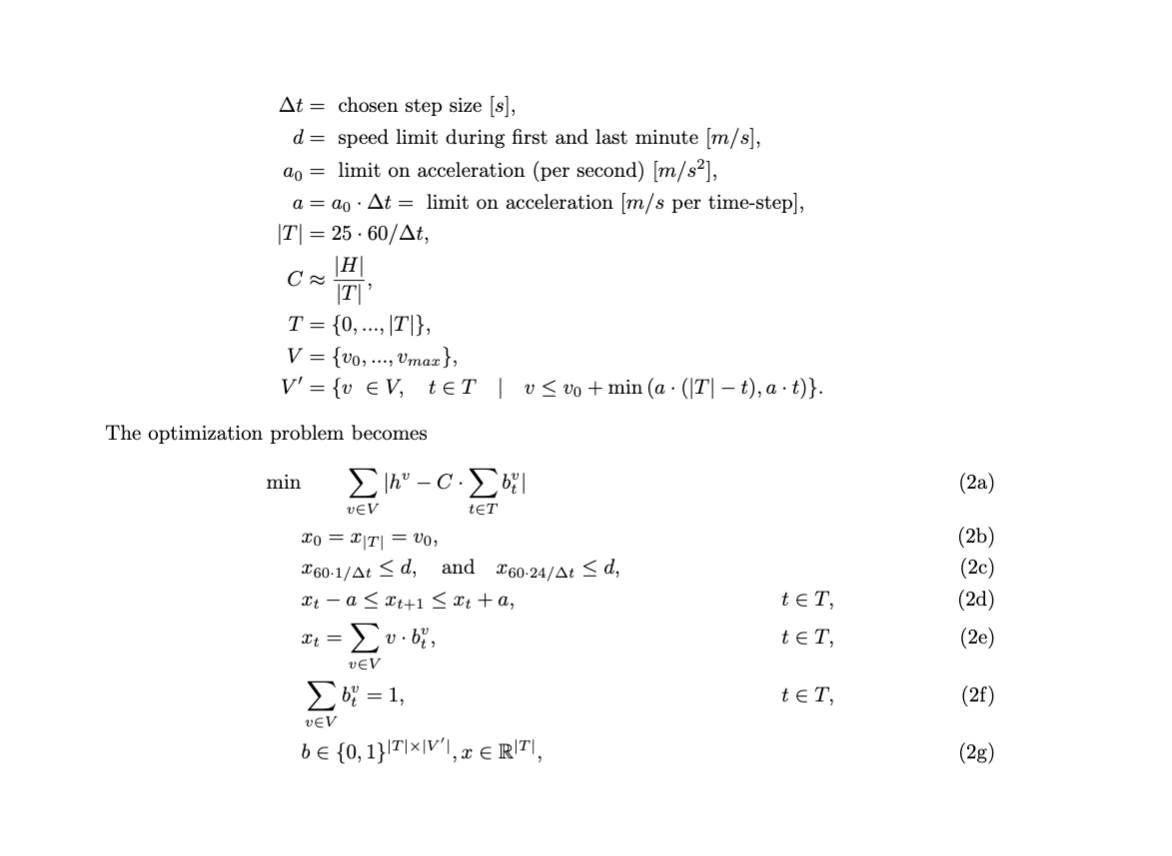

In [2]:
from IPython.display import Image
display(Image(filename='problem_formulation_1_2.png'))

In [3]:
#Data “Stadtradeln 2020”
#The unit of X is [km/h], the unit of Y is [s]
V_20 = [x for x in range(1,51)]
H_20 = [5024.0, 15109.0, 25407.0, 37754.0, 63220.0, 106746.0, 195828.0, 339145.0, 587985.0, 977218.0, 1521230.0, 2254539.0, 3161007.0, 4220219.0, 5382534.0, 6637724.0, 7802254.0, 8708635.0, 9094110.0, 8834248.0, 7846950.0, 6338575.0, 4651152.0, 3127454.0, 2041953.0, 1358565.0, 930478.0, 638112.0, 448834.0, 315900.0, 232795.0, 168504.0, 124620.0, 92653.0, 71160.0, 54409.0, 42382.0, 32513.0, 26013.0, 20612.0, 15783.0, 12515.0, 9633.0, 7781.0, 6232.0, 4767.0, 3944.0, 3197.0, 2493.0, 1010.0]
 
#Data “Stadtradeln 2019”
#The unit of X is [km/h], the unit of Y is [s]
V_19 = [x for x in range(1,51)]
H_19 = [5217.0, 7144.0, 10296.0, 16075.0, 27757.0, 43795.0, 74943.0, 127157.0, 202481.0, 324309.0, 514241.0, 772987.0, 1117721.0, 1518676.0, 2005031.0, 2499377.0, 2942067.0, 3284328.0, 3345193.0, 3173818.0, 2784324.0, 2243990.0, 1632086.0, 1054617.0, 648473.0, 397431.0, 248240.0, 168406.0, 116072.0, 79887.0, 56224.0, 40702.0, 27863.0, 21272.0, 15171.0, 10974.0, 8207.0, 6228.0, 4466.0, 3664.0, 2979.0, 2205.0, 2139.0, 1293.0, 929.0, 945.0, 1025.0, 570.0, 363.0, 141.0]
 

#Data “Stadtradeln 2018”
#The unit of X is [km/h], the unit of Y is [s]
V_18 = [x for x in range(1,51)]
H_18 = [518.0, 1229.0, 2478.0, 4601.0, 8898.0, 13753.0, 21473.0, 35593.0, 57540.0, 86025.0, 129153.0, 195069.0, 281591.0, 382835.0, 501775.0, 628368.0, 735269.0, 810814.0, 823104.0, 803804.0, 732389.0, 629978.0, 484177.0, 335954.0, 207336.0, 125265.0, 74005.0, 47482.0, 32548.0, 22063.0, 15102.0, 9152.0, 7149.0, 5149.0, 3501.0, 2849.0, 2031.0, 1880.0, 1524.0, 1326.0, 1157.0, 1024.0, 1010.0, 752.0, 861.0, 574.0, 772.0, 580.0, 366.0, 244.0]


In [14]:
H = H_20 #choose histogram to use
vel = V_20 #supply the corresponding velocities to H

cycle_length = 25 #[min]; length of cycle
dt = 4 #[s]; time step; divisible by 60; (dt | 60)

a_0 = 1 #[km/h/s]; acceleration per second
a = a_0 * dt #[km/h/timestep]; acceleration per timestep
T = int(cycle_length*60/dt) #total number of time steps

v_0 = vel[0] 

C = sum(H)/(T*1) #scale C so that number of *actual* observations (|H|)..
                             #..roughly coincides with total observations in model (|T|)
                             #this is now further scaled by 2, why this works I do not know, will find out



times = [t for t in range(0,T+1)] #create a vector with all timesteps t
vel_idx = [i for i in range(0,len(vel))] #create a vector of idx for velocities 
                                            #because not all vel. int. - bin size etc.
                                            #wait until data i available to set in stone
I = len(vel_idx)-1
#Note on indexation. Right now vel_idx == vel, but this will not always be the case so;
#velocity will be denoted in two ways; v and i; 
#i denotes the i:th velocity - i.e. vel[i] = v
#we can loop through the velocities in two ways: 
                # "for v in vel" and 
                # "vel[i] for i in vel_idx"
#See creation of b-tuples below 
        
#construct tuplets (time, velocity_index) but only if b(t,i) *can* be true:
#(this corresponds to our definition of V')
#currently implemented for (b)
#Does not alter solution, simply decreases computation (# of binary variables)
tv_pair = [(t,i) for t in times for i in vel_idx if vel[i] <= v_0 + a*min(T-t, t)]



#construct velocity coefficients dictionary
#this is so that we can utilize gurobi function "prod" for easy implementation of constraint (e) later on
coeff = {}
for j in range(len(tv_pair)):
    coeff.update({tv_pair[j]: vel[tv_pair[j][1]]})  #here we assign the velocity "v" to all tuples 
                                                    #tv_pair[j] = (t,i) so tv_pair[j][1] = i, (tv_pair[j][0] = t)
                                                    #i.e., create "triplet" {(t,i):vel[i]};
                                                    #actually we create a dictionary where the unique key (t,i) maps
                                                    #to the value vel[i]

#model
try:
    m = gp.Model("DF")

    b = m.addVars(tv_pair, vtype=GRB.BINARY, name="b") #b(t,i) binary variables (if = 1; choose velocity "vel[i]" at time "t")
    x = m.addVars(times, name="x") #velocity at time t 
    
    
    # diff, u and obj together corresponds to (a) - the objective function:
    diff = m.addVars(vel_idx, lb = -C*T, name="diff")   #diff(i) = h(i) - C*sum(t, b(t,i)) - see constraint "defDiff"
    u = m.addVars(vel_idx, name="u")         #u(i) = abs(diff(i)) - see constraint "absDiff"
    obj = sum(u[i] for i in vel_idx)         #objective = sum(i, u(i))
    
    m.setObjective(obj, GRB.MINIMIZE)
    
    #constraints that help define the variables u(v) in the objective function:
    m.addConstrs((diff[i] == H[i] - C*b.sum("*",i) for i in vel_idx), "defDiff")
    m.addConstrs((u[i] == gp.abs_(diff[i]) for i in vel_idx), "absDiff")
    
    
    #constraint (b);
    #m.addConstr((x[0] == v_0), "start") #initial speed = v_0
    #m.addConstr((x[T] == v_0), "end") #final speed = v_0  
    
    m.addConstr((b[0,0] == 1), "start") #initial speed = v_0
    m.addConstr((b[T,0] == 1), "end") #final speed = v_0  
    
    #constraint (c);
    #not used in current model
    #m.addConstr((x[t] <= d for t in times if t <= one_minute), "first_minute") #limit speed during first minute
    #m.addConstr((x[t] <= d for t in times if t >= T-one_minute), "last_minute") #limit speed during last minute
    
    
    #constraint (d);
    m.addConstrs((x[t] - a <= x[t+1] for t in times if t <= T-1), "accelerate") #increase by max a/timestep
    m.addConstrs((x[t+1] <= x[t] + a for t in times if t <= T-1), "decelerate") #decrease by max a/timestep

    
    #constraint (e)
    m.addConstrs((b.prod(coeff,t,"*") == x[t] for t in times), "assignSpeed") #set speed for time t

    #constraint (f);
    m.addConstrs((b.sum(t,"*") == 1 for t in times), "binaryConstraint") #keep tack of binary variables
    
    #constraint (g);
    #m.addConstr((b.sum("*",vel[-1]) == 1), "reach max speed") #force solution to reach max speed, currently infeasible
    
    m.optimize()
    #for v in m.getVars():
    #    print('%s %g' % (v.VarName, v.X))
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1554 rows, 18626 columns and 56378 nonzeros
Model fingerprint: 0x54a2dc03
Model has 50 general constraints
Variable types: 476 continuous, 18150 integer (18150 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 9e+07]
  RHS range        [1e+00, 9e+06]
Presolve added 86 rows and 0 columns
Presolve removed 0 rows and 5 columns
Presolve time: 0.25s
Presolved: 1640 rows, 18621 columns, 56178 nonzeros
Variable types: 20 continuous, 18601 integer (18148 binary)
Found heuristic solution: objective 1.773016e+08
Found heuristic solution: objective 1.712935e+08

Root relaxation: objective 1.360856e+06, 1553 iterations, 0.13 seconds (0.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |

In [15]:
#example of how to get attributes from solution vectors
x_fin = m.getAttr("X", diff)
x_fin = list(x_fin.values())
x_fin = [round(el) for el in x_fin]
print(x_fin)

[-467514, 15109, 25407, -198515, -173049, 106746, -40441, 102876, 115447, 32141, 103615, -108152, 89508, -32625, -51656, 22188, 5373, -33323, 115883, 92290, 50069, -40692, -74231, 55955, -84469, -59050, -14599, -70695, -23704, 79631, -3474, -67765, -111649, 92653, 71160, 54409, 42382, 32513, 26013, 20612, 15783, 12515, 9633, 7781, 6232, 4767, 3944, 3197, 2493, 1010]


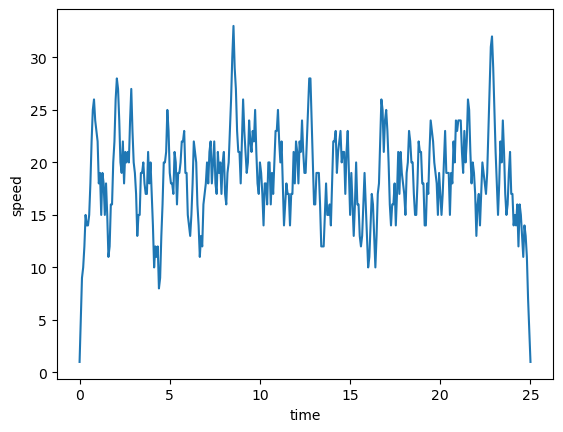

In [16]:
x_min = [x*dt/60 for x in range(0,len(times))]

lr = m.getAttr("X", x)
#plt.plot(list(lr.keys()),list(lr.values()))
plt.plot(x_min,list(lr.values()))
plt.xlabel("time")
plt.ylabel("speed")
#plt.xticks(np.arange(0, 25.1, step=5))
plt.show()


In [9]:
#example of how to get attributes from solution vectors
u_fin = m.getAttr("X", u)
u_fin = list(u_fin.values())
u_fin = [round(el) for el in u_fin]
#print(u_fin)
#print(H)

#print(H)
#print(C*T)
#d = m.getAttr("LB", diff)
#print(d)

In [13]:
#example of how to get attributes from solution vectors
x_fin = m.getAttr("X", b)
#x_fin = list(x_fin.values())
#x_fin = [round(el) for el in x_fin]
print(x_fin)

{(0, 0): 1.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (0, 4): 0.0, (0, 5): 0.0, (0, 6): 0.0, (0, 7): 0.0, (0, 8): 0.0, (0, 9): 0.0, (0, 10): 0.0, (0, 11): 0.0, (0, 12): 0.0, (0, 13): 0.0, (0, 14): 0.0, (0, 15): 0.0, (0, 16): 0.0, (0, 17): 0.0, (0, 18): 0.0, (0, 19): 0.0, (0, 20): 0.0, (0, 21): 0.0, (0, 22): 0.0, (0, 23): 0.0, (0, 24): 0.0, (0, 25): 0.0, (0, 26): 0.0, (0, 27): 0.0, (0, 28): 0.0, (0, 29): 0.0, (0, 30): 0.0, (0, 31): 0.0, (0, 32): 0.0, (0, 33): 0.0, (0, 34): 0.0, (0, 35): 0.0, (0, 36): 0.0, (0, 37): 0.0, (0, 38): 0.0, (0, 39): 0.0, (0, 40): 0.0, (0, 41): 0.0, (0, 42): 0.0, (0, 43): 0.0, (0, 44): 0.0, (0, 45): 0.0, (0, 46): 0.0, (0, 47): 0.0, (0, 48): 0.0, (0, 49): 0.0, (1, 0): -0.0, (1, 1): -0.0, (1, 2): -0.0, (1, 3): -0.0, (1, 4): -0.0, (1, 5): -0.0, (1, 6): -0.0, (1, 7): -0.0, (1, 8): -0.0, (1, 9): 1.0, (1, 10): -0.0, (1, 11): 0.0, (1, 12): 0.0, (1, 13): 0.0, (1, 14): 0.0, (1, 15): 0.0, (1, 16): 0.0, (1, 17): 0.0, (1, 18): 0.0, (1, 19): 0.0, (1, 20): 0.0, (1, 21): 0.0, (